In [ ]:
# import class for web scraping
import requests
from bs4 import BeautifulSoup

# import class for financial data
import yfinance as yf

# import class for data manipulation and analysis
import pandas as pd
import numpy as np

# import class for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# import class for machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.regression.rolling import RollingOLS


# import class for evaluation metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# import class for formalized statisitcial tests
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint

# import class for connection to broker 
from ib_insync import *
import nest_asyncio

# import class(s) for supportive functions
import random
import datetime as dt


In [955]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

r = requests.get(url)
data = r.text
soup = BeautifulSoup(data, 'html.parser')
data = soup.find('table')

df = pd.read_html(str(data))[0]
df.head()


/var/folders/dl/q12jywhx4svgdkc33pp48gq80000gn/T/ipykernel_52702/2269021368.py:8: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(data))[0]


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [956]:
df[df['GICS Sub-Industry'] == 'Semiconductors']

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
6,AMD,Advanced Micro Devices,Information Technology,Semiconductors,"Santa Clara, California",2017-03-20,2488,1969
34,ADI,Analog Devices,Information Technology,Semiconductors,"Wilmington, Massachusetts",1999-10-12,6281,1965
71,AVGO,Broadcom,Information Technology,Semiconductors,"Palo Alto, California",2014-05-08,1730168,1961
195,FSLR,First Solar,Information Technology,Semiconductors,"Tempe, Arizona",2022-12-19,1274494,1999
249,INTC,Intel,Information Technology,Semiconductors,"Santa Clara, California",1976-12-31,50863,1968
314,MCHP,Microchip Technology,Information Technology,Semiconductors,"Chandler, Arizona",2007-09-07,827054,1989
315,MU,Micron Technology,Information Technology,Semiconductors,"Boise, Idaho",1994-09-27,723125,1978
323,MPWR,Monolithic Power Systems,Information Technology,Semiconductors,"Kirkland, Washington",2021-02-12,1280452,1997
346,NVDA,Nvidia,Information Technology,Semiconductors,"Santa Clara, California",2001-11-30,1045810,1993
348,NXPI,NXP Semiconductors,Information Technology,Semiconductors,"Eindhoven, Netherlands",2021-03-22,1413447,1953


In [957]:
tickers_list = df[df['GICS Sub-Industry'] == 'Semiconductors']['Symbol'].tolist()
tickers_list

['AMD',
 'ADI',
 'AVGO',
 'FSLR',
 'INTC',
 'MCHP',
 'MU',
 'MPWR',
 'NVDA',
 'NXPI',
 'ON',
 'QCOM',
 'SWKS',
 'TXN']

In [958]:
current_date = dt.datetime.now().strftime('%Y-%m-%d')
df = yf.download(tickers_list, start = '2020-01-01', end = current_date)['Close']
df

[*********************100%***********************]  14 of 14 completed


Ticker,ADI,AMD,AVGO,FSLR,INTC,MCHP,MPWR,MU,NVDA,NXPI,ON,QCOM,SWKS,TXN
Date,,,,,,,,,,,,,,
2020-01-02,108.940247,49.099998,27.836233,57.240002,53.666458,48.748096,172.722107,54.150463,5.971747,117.315430,25.059999,78.487251,107.541183,110.966995
2020-01-03,107.022476,48.599998,27.128223,57.020000,53.013710,47.678902,169.594101,53.309704,5.876163,116.183723,24.690001,77.009369,104.871857,109.493904
2020-01-06,105.765099,48.389999,27.087639,55.830002,52.863754,46.994793,167.857422,52.371193,5.900805,115.362320,24.070000,76.558044,103.024559,108.731705
2020-01-07,108.171310,48.250000,26.994387,56.669998,51.981670,50.148029,169.421432,56.966011,5.972246,116.859070,24.660000,78.735046,104.005653,110.829971
2020-01-08,109.148285,47.830002,26.657644,56.700001,52.016968,49.513752,169.200699,56.232796,5.983446,117.151154,24.820000,78.504959,105.658501,111.129700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,236.960007,143.809998,269.350006,152.139999,22.690001,70.489998,734.470032,124.760002,157.750000,217.039993,52.930000,158.539993,74.800003,207.080002
2025-06-30,238.020004,141.899994,275.649994,165.539993,22.400000,70.370003,731.380005,123.250000,157.990005,218.490005,52.410000,159.259995,74.519997,207.619995
2025-07-01,240.639999,136.110001,264.739990,162.960007,22.850000,71.680000,746.969971,120.889999,153.300003,221.210007,53.599998,159.399994,77.160004,210.449997


In [959]:
def cointegration_pairs(df, threshold=0.05):
    pairs = []
    for i in range(len(df.columns)):
        for j in range(i + 1, len(df.columns)):
            stock1 = df.iloc[:, i]
            stock2 = df.iloc[:, j]
            score, p_value, _ = coint(stock1, stock2)
            if p_value < threshold:
                pairs.append((df.columns[i], df.columns[j], p_value))
    return pairs

In [960]:
list_of_pairs = cointegration_pairs(df, threshold=0.05)
sorted_pairs = sorted(list_of_pairs, key=lambda x: x[2])
for pair in sorted_pairs:
    print(f'Stock 1: {pair[0]}, Stock 2: {pair[1]}, p-value: {pair[2]:.4f}')
    pvalues = [pair[2] for pair in sorted_pairs]

Stock 1: ADI, Stock 2: MPWR, p-value: 0.0231
Stock 1: MPWR, Stock 2: MU, p-value: 0.0247
Stock 1: AMD, Stock 2: NXPI, p-value: 0.0399


In [961]:
highest_p_val = sorted_pairs[-1][0:2]
highest_p_val

('AMD', 'NXPI')

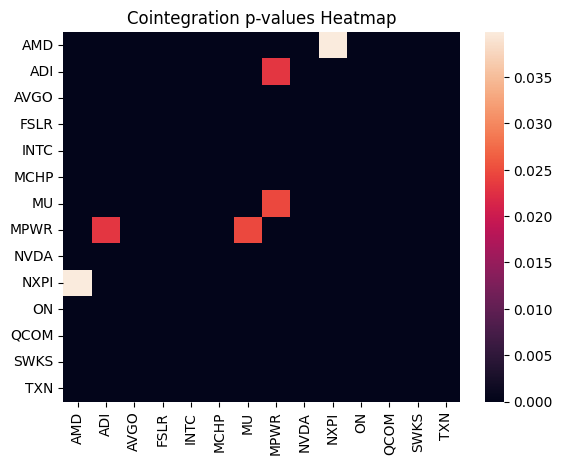

In [962]:
# Create a matrix of p-values
pvalues_matrix = np.zeros((len(tickers_list), len(tickers_list)))
for pair in sorted_pairs:
    i = tickers_list.index(pair[0])
    j = tickers_list.index(pair[1])
    pvalues_matrix[i, j] = pair[2]
    pvalues_matrix[j, i] = pair[2]  # Mirror the values

# Create heatmap
sns.heatmap(
    pvalues_matrix,
    xticklabels=tickers_list,
    yticklabels=tickers_list,
    mask=(pvalues_matrix > 0.10)
)
plt.title('Cointegration p-values Heatmap')
plt.show()

In [963]:
stock1 = df[f'{highest_p_val[0]}']
stock2 = df[f'{highest_p_val[1]}']

In [964]:
results = sm.OLS(stock2, stock1).fit()
b = results.params[0]
spread = stock2 - b * stock1

/var/folders/dl/q12jywhx4svgdkc33pp48gq80000gn/T/ipykernel_52702/2601335917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b = results.params[0]


In [965]:
hedge_ratio = results.params[0]
print('Hedge Ratio = ', hedge_ratio)

Hedge Ratio =  1.6565888059822416


/var/folders/dl/q12jywhx4svgdkc33pp48gq80000gn/T/ipykernel_52702/2668187976.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = results.params[0]


In [966]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   NXPI   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                          5.376e+04
Date:                Fri, 04 Jul 2025   Prob (F-statistic):                        0.00
Time:                        12:06:55   Log-Likelihood:                         -6628.2
No. Observations:                1383   AIC:                                  1.326e+04
Df Residuals:                    1382   BIC:                                  1.326e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AMD            1.6566      0.007    231.855      0.000       1.643       1.671
==============================================================================
Omnibus:                      106.514   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.694
Skew:                          -0.666   Prob(JB):                     1.26e-30
Kurtosis:                       3.785   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [967]:
spread

Date
2020-01-02    35.976922
2020-01-03    35.673510
2020-01-06    35.199989
2020-01-07    36.928660
2020-01-08    37.916508
                ...    
2025-06-27   -21.194039
2025-06-30   -16.579936
2025-07-01    -4.268297
2025-07-02     1.679305
2025-07-03     3.639838
Length: 1383, dtype: float64

In [968]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

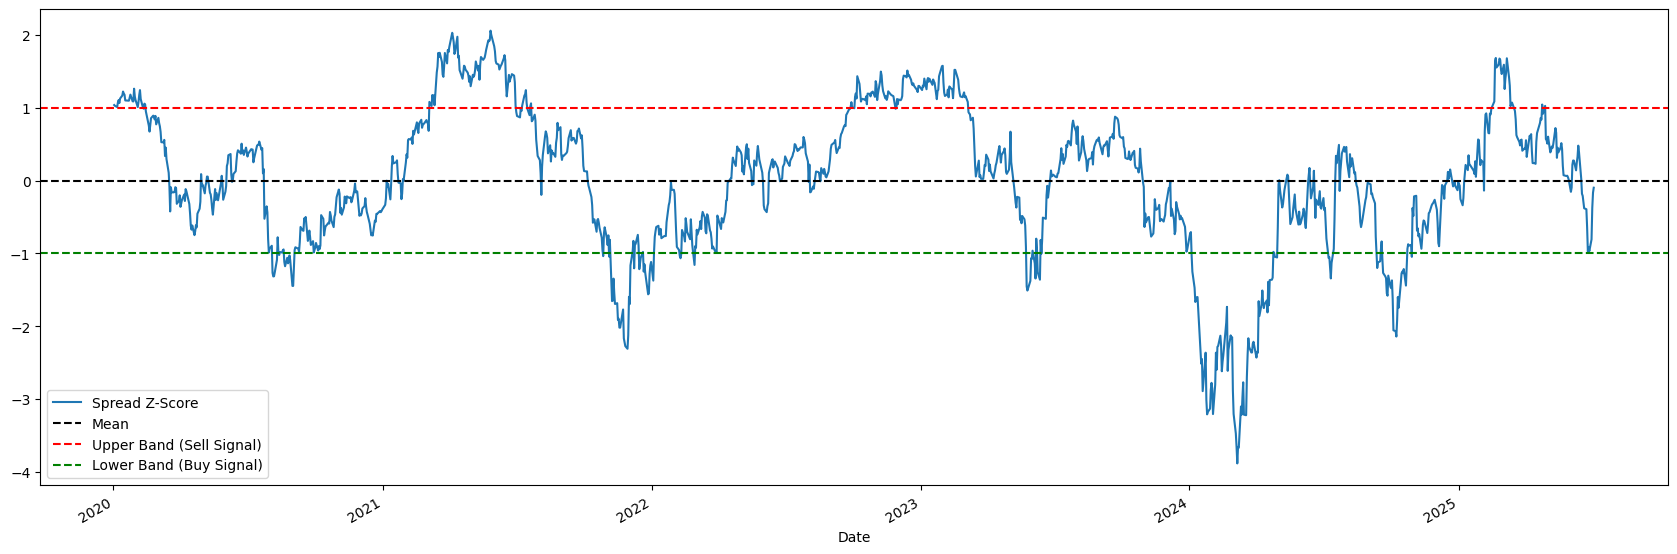

In [969]:
zscore(spread).plot(figsize=(21,7))
plt.axhline(zscore(spread).mean(), color='black', linestyle='--')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread Z-Score', 'Mean', 'Upper Band (Sell Signal)', 'Lower Band (Buy Signal)'])

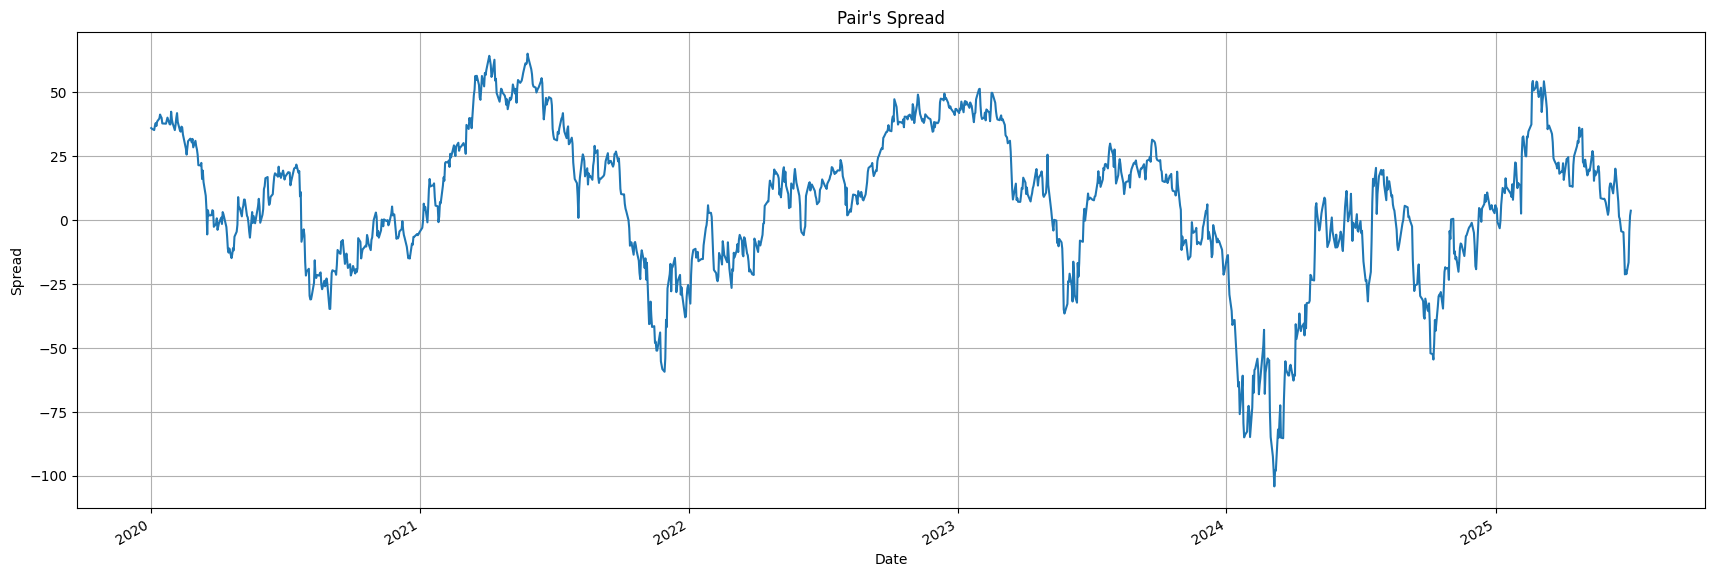

In [970]:
#plotting the spread
## May Not need this graphic, but keeping it for reference
plot = spread.plot(figsize=(21,7), title="Pair's Spread")
plot.set_ylabel('Spread')
plot.grid(True)

Text(0.5, 1.0, 'Closing Price of AMD and NXPI')

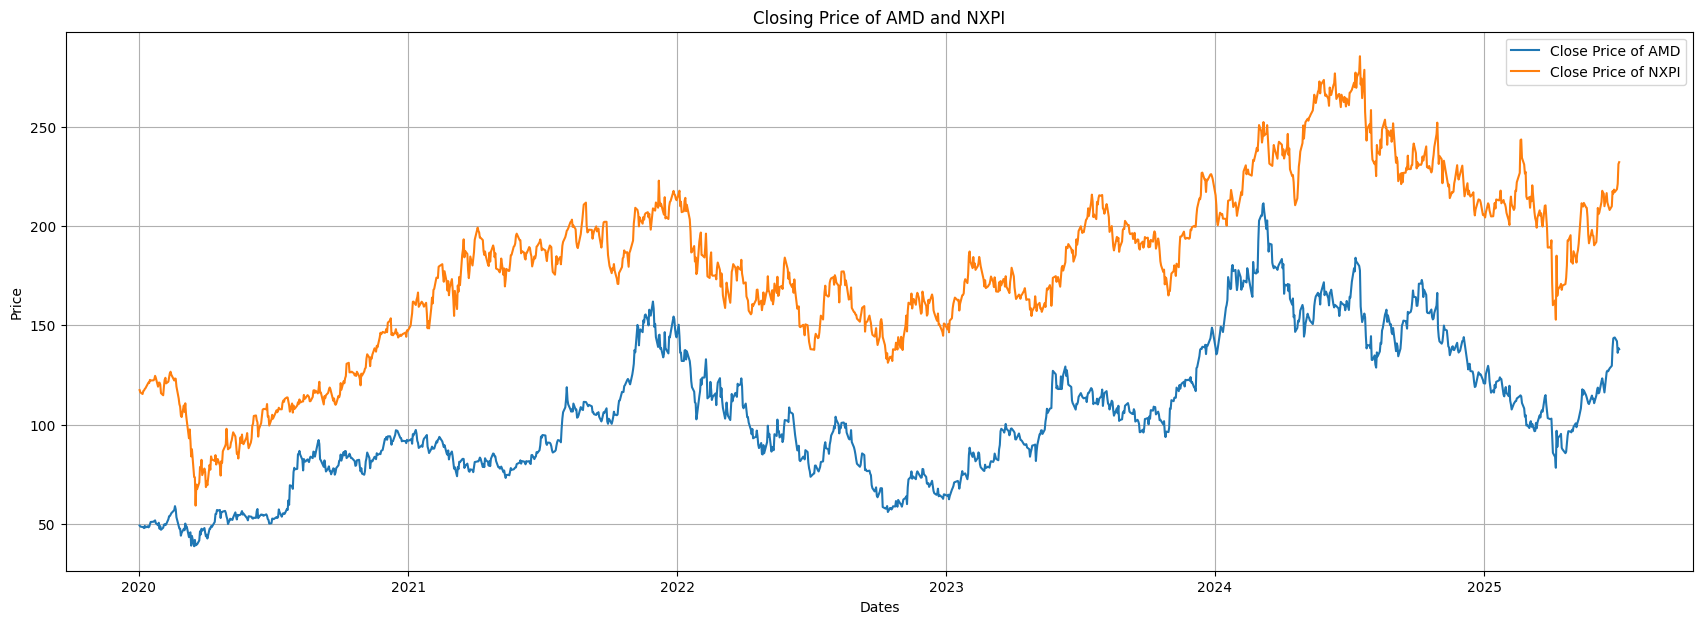

In [971]:
plt.figure(figsize=(21, 7))
plt.plot(stock1, lw=1.5, label=f'Close Price of {highest_p_val[0]}')
plt.plot(stock2, lw=1.5, label=f'Close Price of {highest_p_val[1]}')
plt.grid(True)
plt.legend(loc=0)

plt.axis('tight')
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title(f'Closing Price of {highest_p_val[0]} and {highest_p_val[1]}')

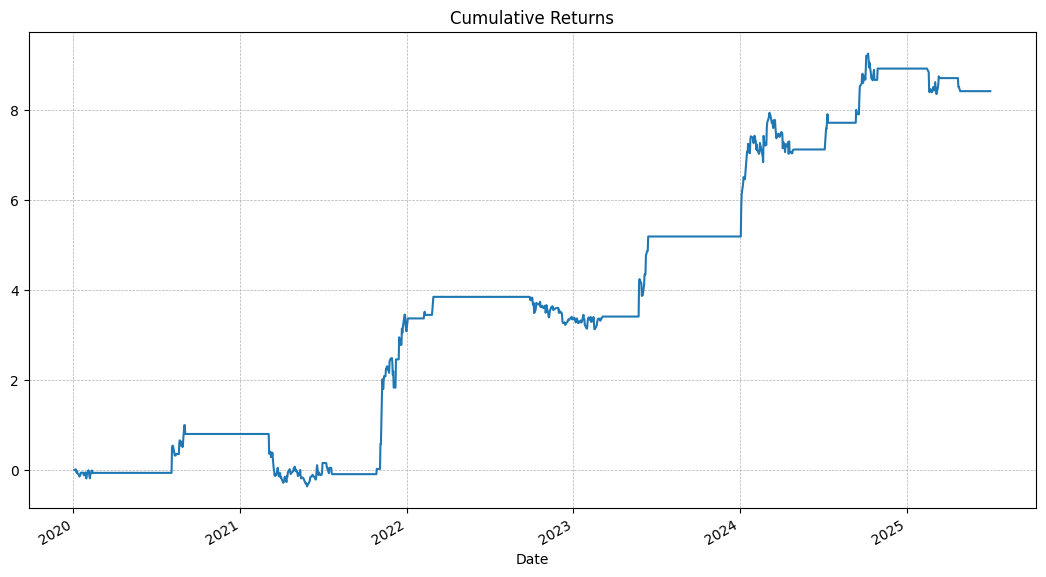

In [972]:
bt_df = pd.concat([zscore(spread), stock2 - b * stock1], axis=1)
bt_df.columns = ['signal', 'position']

bt_df['side'] = 0
bt_df.loc[bt_df['signal'] <= -1, 'side'] = 1
bt_df.loc[bt_df['signal'] >= 1, 'side'] = -1

returns = bt_df.position.pct_change() * bt_df.side
returns.cumsum().plot(figsize=(13,7), title="Cumulative Returns")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


In [973]:
df = df[[f'{highest_p_val[0]}', f'{highest_p_val[1]}']]
df

Ticker,AMD,NXPI
Date,,
2020-01-02,49.099998,117.315430
2020-01-03,48.599998,116.183723
2020-01-06,48.389999,115.362320
2020-01-07,48.250000,116.859070
2020-01-08,47.830002,117.151154
...,...,...
2025-06-27,143.809998,217.039993
2025-06-30,141.899994,218.490005
2025-07-01,136.110001,221.210007


In [974]:
df = df.join(
    spread.rename('spread'),
    how='inner'
)

In [975]:
df['next_spread'] = df['spread'].shift(-1)
df.dropna(inplace=True)

In [976]:
# Need to add dependency for train_test_split
x_test, x_train, y_test, y_train = train_test_split(
    df.drop('next_spread', axis=1).values,
    df['next_spread'].values,
    test_size=0.2,
    shuffle=False
)

In [977]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [ ]:
y_pred = lr_model.predict(x_test)
y_pred

array([36.17840814, 35.90239156, 35.45881035, ..., -8.04141274,
       -4.59761038, -1.8818791 ])

In [979]:
abs_mae_lr = mean_absolute_error(y_test, y_pred)
rmse_lr = root_mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print(f'Linear Regression Mean Absolute Error: {abs_mae_lr:.2f}')
print(f'Linear Regression RMSE: {rmse_lr:.2f}')
print(f'Linear Regression R^2: {r2_lr:.2f}')

Linear Regression Mean Absolute Error: 3.32
Linear Regression RMSE: 4.66
Linear Regression R^2: 0.98


In [980]:
# Checking for overfitting
act_val = lr_model.score(x_train, y_train)
pred_val = lr_model.score(x_test, y_test)
print(f'r2 score for training set: {act_val:.2f}')
print(f'r2 score for test set: {pred_val:.2f}')

r2 score for training set: 0.94
r2 score for test set: 0.98


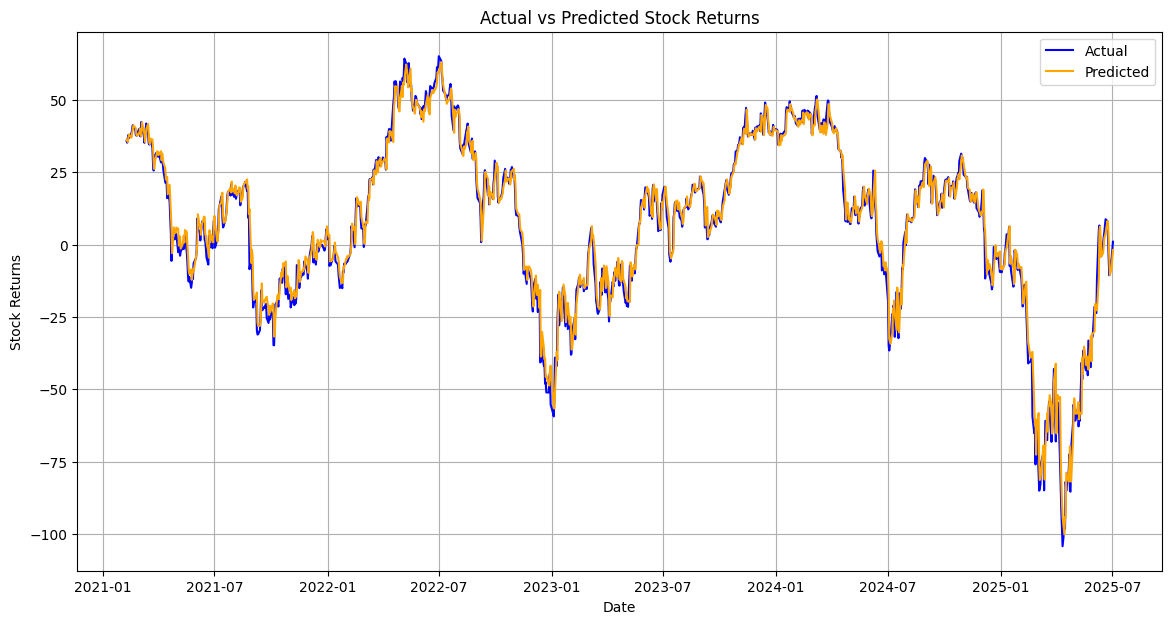

In [981]:
plt.figure(figsize=(14, 7))
# Get the dates from the original DataFrame
test_dates = df.index[-len(y_test):]

plt.plot(test_dates, y_test, label='Actual', color='blue')
plt.plot(test_dates, y_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted Stock Returns')
plt.xlabel('Date')
plt.ylabel('Stock Returns')
plt.legend()
plt.grid()

Text(0, 0.5, 'Predicted Values')

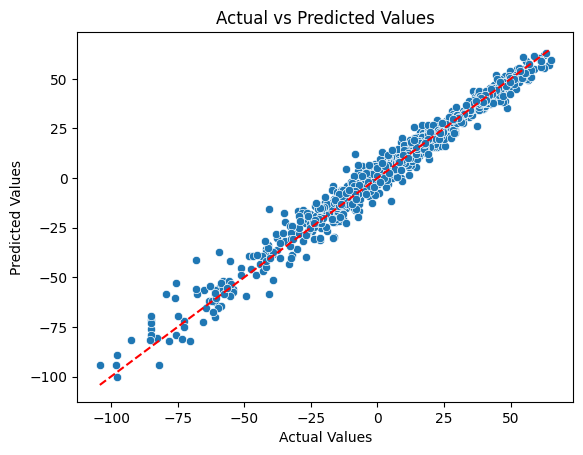

In [982]:
act_val = lr_model.score(x_train, y_train)
predict_val = lr_model.score(x_test, y_test)
sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x = np.linspace(y_test.min(), y_test.max(), 100), 
             y = np.linspace(y_test.min(), y_test.max(), 100), 
             color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

Text(0, 0.5, 'Residuals')

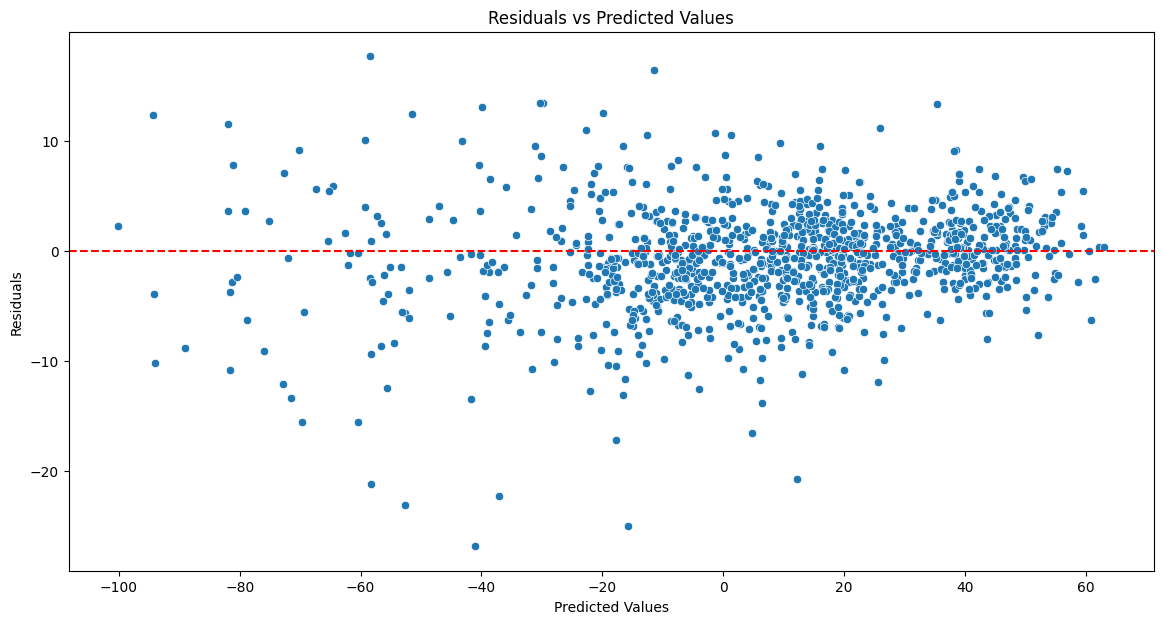

In [983]:
residuals = y_test - y_pred
plt.figure(figsize=(14, 7))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

<Figure size 1400x700 with 0 Axes>

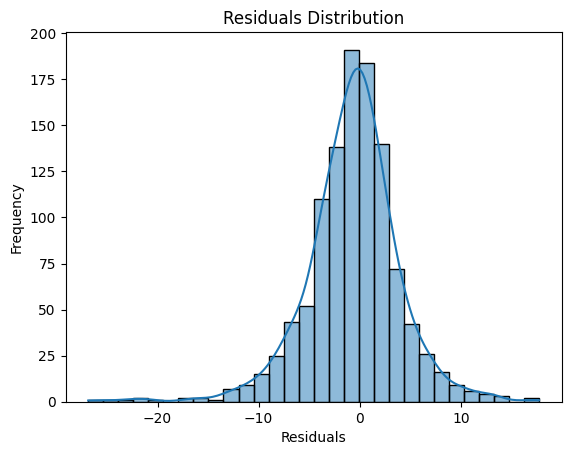

<Figure size 1400x700 with 0 Axes>

In [984]:
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.figure(figsize=(14, 7))


Text(0, 0.5, 'Sample Quantiles')

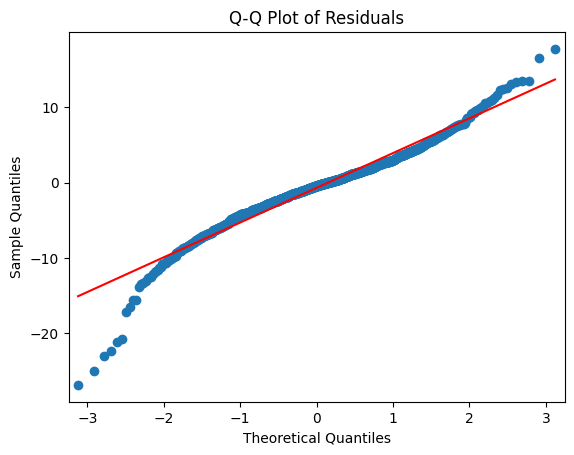

In [985]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

In [ ]:
# Instantiate the IB class and connect to IBKR broker
nest_asyncio.apply()
ib = IB()
ib.connect('127.0.0.1', 7497, clientId = random.randint(1,99)) # Using port 7497 for PAPER trading
# ib.connect('127.0.0.1', 7496, clientId = random.randint(1,99)) # Using port 7496 for LIVE trading

In [ ]:
# Create a function to buy stock
def buy_stock(ticker: str):
        
        # Checking the account balance
        acct_bal = float(ib.accountSummary()[9].value)
        
        stock = Stock(
            symbol = ticker, 
            exchange = 'SMART', 
            currency = 'USD'
        )
        
        # Need to factor in the hedge ratio to determine the amount of stock to buy
        purchase_amount = 1

        action = Order(
            action = 'BUY', 
            totalQuantity = round(purchase_amount.item()), 
            orderType = 'MKT',  
            tif = 'GTC', 
            outsideRth = True
        ) 
        
        order = ib.placeOrder(stock, action)

        while True:
            ib.waitOnUpdate() # Wait on any new update(s) to arrive from the network.

In [ ]:
# Function to sell stock
def sell_stock(ticker: str):
        
        stock = Stock(
            symbol = ticker, 
            exchange = 'SMART', 
            currency = 'USD'
        )

        amount_bought = ib.positions().position

        sell_amount = amount_bought * hedge_ratio  # Adjusting sell amount based on hedge ratio

        action = Order(
            action = 'SELL', 
            totalQuantity = sell_amount, 
            orderType = 'MKT',  
            tif = 'GTC', 
            outsideRth = True
        )
        
        order = ib.placeOrder(stock, action)

In [ ]:
if y_pred[-1] > 0:
    print(f"Buying {highest_p_val[0]} stock and selling {highest_p_val[1]} stock")
    try:
        buy_stock(highest_p_val[0])
        sell_stock(highest_p_val[1])
    except Exception as e:
        print(f"Error occurred: {e}")

elif y_pred[-1] < 0:
    print(f"Selling {highest_p_val[0]} stock and buying {highest_p_val[1]} stock")
    try:
        buy_stock(highest_p_val[1])
        sell_stock(highest_p_val[0])
    except Exception as e:
        print(f"Error occurred: {e}")

In [ ]:
ib.disconnect()
# Disconnect from the IBKR broker
print("Disconnected from IBKR broker.")